In [2]:
from hydra.utils import instantiate
import numpy as np
from omegaconf import OmegaConf
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score
import torch
from torch import nn
from tqdm import tqdm
import hydra
import timm

In [ ]:


y = alpha * x + beta * x**2

In [6]:
model = timm.create_model('efficientnet_b0')
model

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequenti

In [5]:
import albumentations as A

In [ ]:
A.Cutout(num_holes=1, max_h_size=512, max_w_size=3, fill_value=1.0, p=0.25)

In [2]:
from torch.utils.data import Dataset, DataLoader

class SimpleTargetLoader(Dataset):
    def __init__(self, df):
        super().__init__()
        self.labels = df.target.values
        self.ids = df.id.values
        self.flags = df.flag.values

    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        ids = self.ids[idx]
        flag = self.flags[idx]
        im = np.load(f"data/{flag}/{ids[0]}/{ids}.npy")[0].astype(np.float32)
        return np.stack((im, im, im)), label

def get_embeddings(model, loader, device='cuda:0'):
    model.to(device)
    model.eval()
    embeddings = []
    with torch.no_grad():
        for batch in tqdm(loader):
            x, y = batch
            embeds = model.forward_features(x.cuda()).mean(2).mean(2)
            embeddings.append(embeds)
    return embeddings

In [3]:
EXPERIMENT = "effv2s_norm1_p05"
DEVICE = "cuda:0"

In [4]:
tr = pd.read_csv("data/train_labels.csv")
tr['flag'] = "train"
tr.shape

(50165, 3)

In [5]:
te = pd.read_csv("data/sample_submission.csv")
te.shape

(35847, 2)

In [35]:
model = timm.create_model('resnest50d', pretrained=True)
ds = SimpleTargetLoader(tr)
dl = DataLoader(ds, shuffle=False, drop_last=False, batch_size=32, num_workers=8, pin_memory=True)

In [36]:
embeds = get_embeddings(model, dl, DEVICE)

100%|██████████| 1568/1568 [01:36<00:00, 16.22it/s]


In [39]:
embedsnp = torch.cat(embeds).cpu().numpy()

In [46]:
from sklearn.preprocessing import normalize
embedsnpl2 = normalize(embedsnp)

In [92]:
sims = embedsnpl2[:24]@embedsnpl2.T
sims

array([[0.99999976, 0.5995618 , 0.3002862 , ..., 0.65471166, 0.7857692 ,
        0.4720085 ],
       [0.5995618 , 1.0000004 , 0.3372168 , ..., 0.6901097 , 0.49904633,
        0.35718143],
       [0.3002862 , 0.3372168 , 1.        , ..., 0.40708435, 0.27788484,
        0.19898346],
       ...,
       [0.6455906 , 0.85945   , 0.31280005, ..., 0.7598959 , 0.6149218 ,
        0.42119053],
       [0.30871153, 0.46093404, 0.44960648, ..., 0.47142678, 0.28938803,
        0.16595906],
       [0.7266928 , 0.35839152, 0.2824822 , ..., 0.580094  , 0.8562343 ,
        0.4736091 ]], dtype=float32)

In [112]:
np.where(sims[20] > 0.95)

(array([   20,  2358,  2592,  2984,  4549,  4726,  5072,  9378, 10052,
        10326, 10879, 11815, 12972, 14039, 15123, 16567, 17156, 17512,
        19706, 20593, 20711, 20815, 22788, 22973, 23096, 23367, 24926,
        25175, 26132, 27792, 28410, 30064, 30243, 30611, 32579, 33797,
        36471, 37593, 38847, 39085, 39122, 42906, 44200, 46118, 47638,
        48709, 49591]),)

In [234]:
import matplotlib.pyplot as plt
def plot_image(df, idx):
    ids = df.id.iloc[idx]
    im = np.load(f"data/{df.flag.iloc[idx]}/{ids[0]}/{ids}.npy")[[0, 2, 4]].astype(np.float32)
    im = np.vstack(im)
    im -= im.min()
    im /= im.max()
    plt.figure(figsize=(15, 15))
    plt.imshow(im)
    plt.show()

In [119]:
tr.iloc[10052]

id        331d99eaaff2
target               0
flag             train
Name: 10052, dtype: object

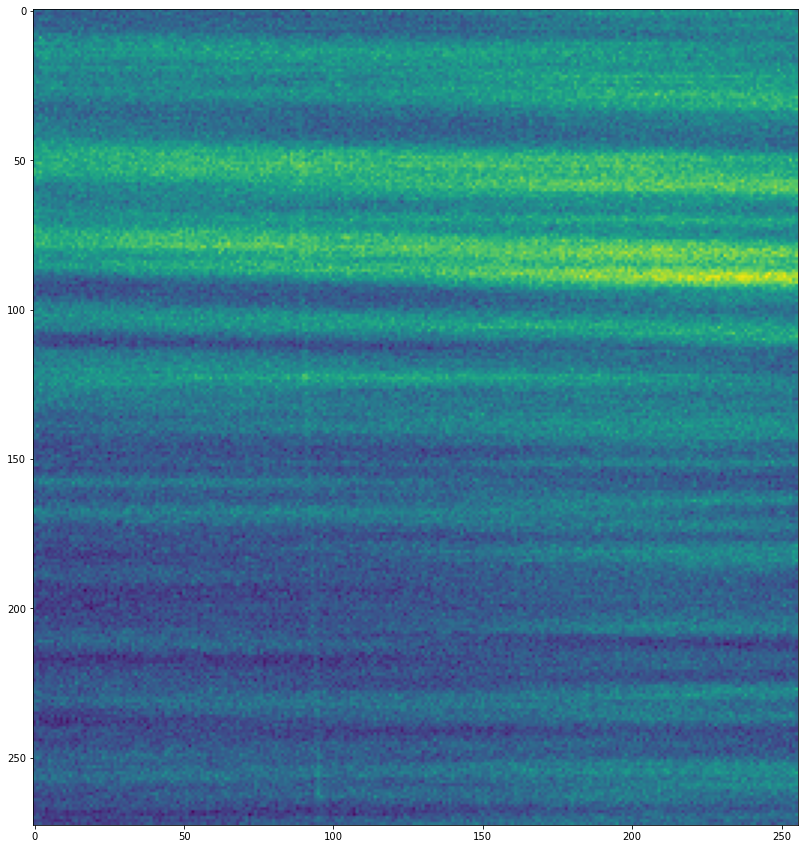

In [109]:
plot_image(tr, 20)


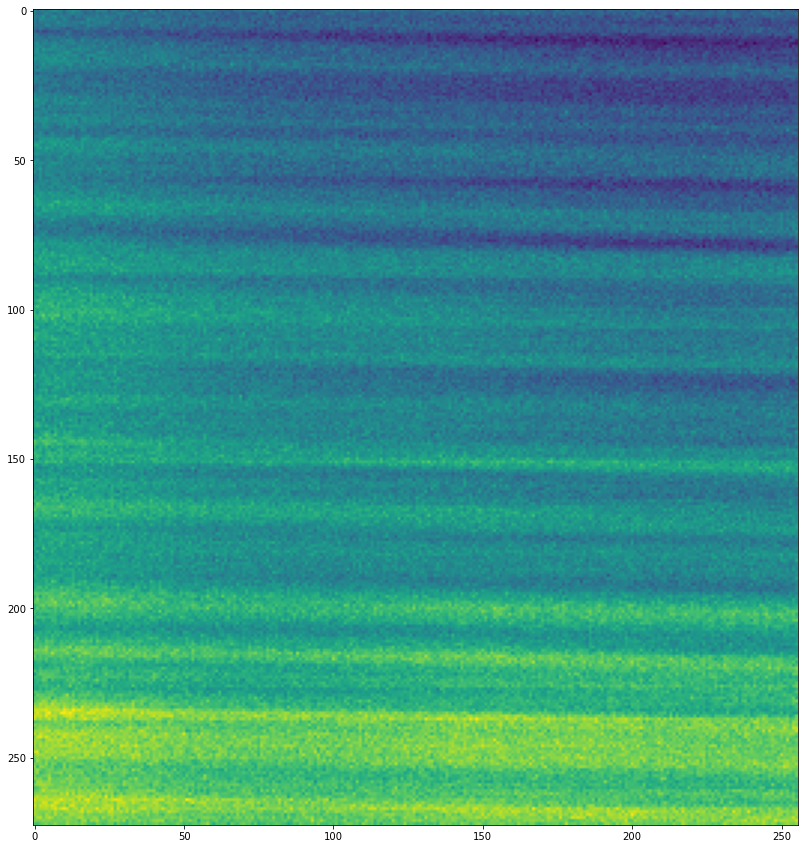

In [116]:
plot_image(tr, 4726)

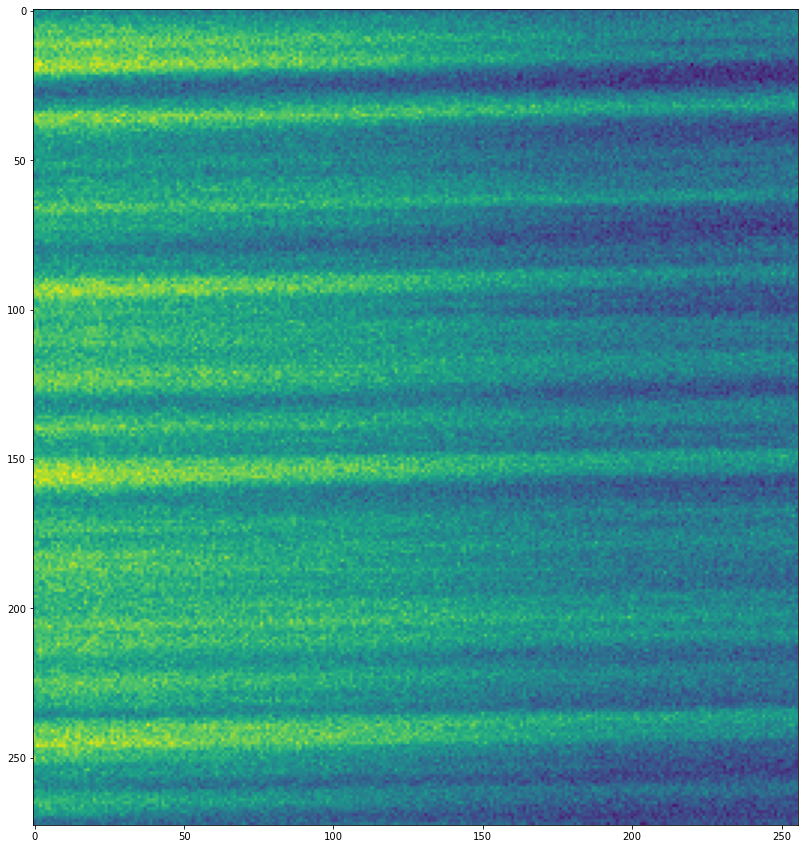

In [111]:
plot_image(tr, 44200)

In [5]:
config = OmegaConf.load(f"configs/experiment/{EXPERIMENT}.yaml")

# changes
config.data_dir ="data"
config.trainer.gpus=[0]
if "train_transforms" in config:
    train_transforms = hydra.utils.call(config.train_transforms)
else:
    train_transforms = None
if "test_transforms" in config:
    test_transforms = hydra.utils.call(config.test_transforms)
else:
    test_transforms = None
# Init Lightning datamodule
datamodule = hydra.utils.instantiate(config.datamodule,
                                     train_transforms=train_transforms,
                                     test_transforms=test_transforms)
datamodule.setup()

In [6]:
device=0
config.datamodule.val_fold = 0
model = hydra.utils.instantiate(config.model)
checkpoints = list(Path(f"./logs/runs/{config.experiment_name}/{config.model.backbone}/{config.datamodule.val_fold}/checkpoints").glob("*/*.ckpt"))
best_checkpoint = max(checkpoints, key=lambda x: float(x.stem.split("=")[1]))
model.load_state_dict(torch.load(best_checkpoint, map_location=f"cuda:{device}")['state_dict'])
trainer = hydra.utils.instantiate(config.trainer)
trainer.logger = None
vpreds = trainer.test(model, datamodule.val_dataloader())[0]['outputs']
vlabels = datamodule.val_data.labels

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 100%|██████████| 279/279 [01:03<00:00,  4.37it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'outputs': array([0.008644, 0.006878, 0.00784 , ..., 0.004005, 0.003298, 0.02718 ],
      dtype=float16)}
--------------------------------------------------------------------------------


In [7]:
datamodule.train_data.transforms.transforms.transforms

[Resize(always_apply=False, p=1, height=512, width=512, interpolation=4),
 Normalize(always_apply=False, p=1.0, mean=0.5, std=0.5, max_pixel_value=1.0)]

In [108]:
def get_preds(experiment, device, folds):
    config = OmegaConf.load(f"configs/experiment/{experiment}.yaml")
    
    # changes
    config.data_dir ="data"
    config.trainer.gpus=[device]
    if "train_transforms" in config:
        train_transforms = hydra.utils.instantiate(config.train_transforms)
    else:
        train_transforms = None
    if "test_transforms" in config:
        test_transforms = hydra.utils.instantiate(config.test_transforms)
    else:
        test_transforms = None
    # Init Lightning datamodule


    # Init Lightning model
    val_preds, test_preds, val_labels, val_ids = [], [], [], []
    for fold in folds:
        config.datamodule.val_fold = fold
        datamodule = hydra.utils.instantiate(config.datamodule,
                                             train_transforms=train_transforms,
                                             test_transforms=test_transforms)
        datamodule.setup()

        model = hydra.utils.instantiate(config.model)
        checkpoints = list(Path(f"./logs/runs/{config.experiment_name}/{config.model.backbone}/{config.datamodule.val_fold}/checkpoints").glob("*/*.ckpt"))
        best_checkpoint = max(checkpoints, key=lambda x: float(x.stem.split("=")[1]))
        model.load_state_dict(torch.load(best_checkpoint, map_location=f"cuda:{device}")['state_dict'])
        trainer = hydra.utils.instantiate(config.trainer)
        trainer.logger = None
        vpreds = trainer.test(model, datamodule.val_dataloader())[0]['outputs']
        vlabels = datamodule.val_data.labels

        tpreds = trainer.test(model, datamodule.test_dataloader())[0]['outputs']
        val_preds.extend(vpreds)
        test_preds.append(tpreds)
        val_labels.extend(vlabels)
        val_ids.extend(datamodule.val_data.ids.tolist())
        sub = pd.DataFrame({"id": datamodule.val_data.ids, 'target': vpreds})
        sub.to_csv(f"sub_oof_{config.experiment_name}_{fold}.csv", index=False)        
    print("OOF ROC-AUC ", roc_auc_score(val_labels, val_preds))
    test_preds = np.mean(test_preds, 0)
    sub = pd.DataFrame({"id": datamodule.test_data.ids, 'target': test_preds})
    sub.to_csv(f"sub_test_{config.experiment_name}_{''.join([str(f) for f in folds])}.csv", index=False)
    return val_preds, val_ids, test_preds

In [109]:
val_preds1, val_ids1, test_preds = get_preds(EXPERIMENT, 0, [0,1,2,3,4])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 100%|██████████| 279/279 [01:05<00:00,  4.25it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'outputs': array([0.008644, 0.006878, 0.00784 , ..., 0.004005, 0.003298, 0.02718 ],
      dtype=float16)}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 100%|██████████| 996/996 [03:53<00:00,  4.26it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'outputs': array([0.01086 , 0.008545, 0.00639 , ..., 0.01099 , 0.01169 , 0.002481],
      dtype=float16)}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 100%|██████████| 279/279 [01:04<00:00,  4.34it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'outputs': array([0.005302, 0.2     , 0.006905, ..., 0.002378, 0.01883 , 0.0052  ],
      dtype=float16)}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 996/996 [03:50<00:00,  4.32it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'outputs': array([0.0181  , 0.004887, 0.0056  , ..., 0.01001 , 0.01133 , 0.003765],
      dtype=float16)}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 100%|██████████| 279/279 [01:06<00:00,  4.22it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'outputs': array([0.005867, 0.00205 , 0.01037 , ..., 0.007637, 0.004963, 0.00649 ],
      dtype=float16)}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 100%|██████████| 996/996 [03:51<00:00,  4.30it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'outputs': array([0.008316, 0.00629 , 0.01049 , ..., 0.00522 , 0.01423 , 0.003052],
      dtype=float16)}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 100%|██████████| 279/279 [01:05<00:00,  4.24it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'outputs': array([0.00743 , 0.004906, 0.003635, ..., 0.005844, 0.02145 , 0.012054],
      dtype=float16)}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 100%|██████████| 996/996 [03:50<00:00,  4.31it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'outputs': array([0.01348 , 0.00956 , 0.004906, ..., 0.008415, 0.01758 , 0.00803 ],
      dtype=float16)}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 100%|██████████| 279/279 [01:05<00:00,  4.29it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'outputs': array([0.007637, 0.003027, 0.006096, ..., 0.01169 , 0.003551, 0.006668],
      dtype=float16)}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 996/996 [03:50<00:00,  4.31it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'outputs': array([0.00838 , 0.04272 , 0.01554 , ..., 0.006798, 0.0161  , 0.003565],
      dtype=float16)}
--------------------------------------------------------------------------------
OOF ROC-AUC  0.9898910201239149


In [70]:
def get_preds2(experiment, device, folds):
    config = OmegaConf.load(f"configs/experiment/{experiment}.yaml")
    # changes
    config.data_dir ="data"
    # config.test_transforms.transforms[0].height = 384
    # config.test_transforms.transforms[0].width = 384
    config.datamodule.norm = 2
    config.trainer.gpus=[device]
    if "train_transforms" in config:
        train_transforms = hydra.utils.instantiate(config.train_transforms)
    else:
        train_transforms = None
    if "test_transforms" in config:
        test_transforms = hydra.utils.instantiate(config.test_transforms)
    else:
        test_transforms = None
    # Init Lightning datamodule
    print(test_transforms.transforms)


    # Init Lightning model
    val_preds, test_preds, val_labels, val_ids = [], [], [], []
    for fold in folds:
        config.datamodule.val_fold = fold
        datamodule = hydra.utils.instantiate(config.datamodule,
                                             train_transforms=train_transforms,
                                             test_transforms=test_transforms)
        datamodule.setup()

        model = hydra.utils.instantiate(config.model)
        checkpoints = list(Path(f"./logs/runs/{config.experiment_name}/{config.model.backbone}/{config.datamodule.val_fold}/checkpoints").glob("*/*.ckpt"))
        best_checkpoint = max(checkpoints, key=lambda x: float(x.stem.split("=")[1]))
        model.load_state_dict(torch.load(best_checkpoint, map_location=f"cuda:{device}")['state_dict'])
        trainer = hydra.utils.instantiate(config.trainer)
        trainer.logger = None
        vpreds = trainer.test(model, datamodule.val_dataloader())[0]['outputs']
        vlabels = datamodule.val_data.labels

        tpreds = trainer.test(model, datamodule.test_dataloader())[0]['outputs']
        #tpreds = []
        val_preds.extend(vpreds)
        test_preds.append(tpreds)
        val_labels.extend(vlabels)
        val_ids.extend(datamodule.val_data.ids.tolist())
        sub = pd.DataFrame({"id": datamodule.val_data.ids, 'target': vpreds})
        sub.to_csv(f"sub_oof_{config.experiment_name}_{fold}.csv", index=False)        
    print("OOF ROC-AUC ", roc_auc_score(val_labels, val_preds))
    test_preds = np.mean(test_preds, 0)
    sub = pd.DataFrame({"id": datamodule.test_data.ids, 'target': test_preds})
    sub.to_csv(f"sub_test_{config.experiment_name}_{''.join([str(f) for f in folds])}.csv", index=False)
    return val_preds, val_ids, test_preds

val_preds2, val_ids1, test_preds2 = get_preds2(EXPERIMENT, 0, [0,1,2,3,4])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 100%|██████████| 279/279 [01:06<00:00,  4.20it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'outputs': array([0.008064, 0.02045 , 0.006462, ..., 0.02237 , 0.0181  , 0.02025 ],
      dtype=float16)}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 996/996 [03:49<00:00,  4.34it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'outputs': array([0.008675, 0.01343 , 0.0477  , ..., 0.02065 , 0.015366, 0.0627  ],
      dtype=float16)}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 100%|██████████| 279/279 [01:07<00:00,  4.14it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'outputs': array([0.00956 , 0.397   , 0.00784 , ..., 0.00888 , 0.003975, 0.011246],
      dtype=float16)}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 996/996 [03:49<00:00,  4.33it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'outputs': array([0.01029 , 0.005405, 0.5     , ..., 0.01718 , 0.01554 , 0.1799  ],
      dtype=float16)}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 100%|██████████| 279/279 [01:05<00:00,  4.27it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'outputs': array([0.002947, 0.01017 , 0.01698 , ..., 0.0093  , 0.01317 , 0.00752 ],
      dtype=float16)}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 996/996 [03:52<00:00,  4.28it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'outputs': array([0.00881 , 0.01243 , 0.008095, ..., 0.01616 , 0.02571 , 0.008675],
      dtype=float16)}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 100%|██████████| 279/279 [01:06<00:00,  4.18it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'outputs': array([0.00378 , 0.00485 , 0.01001 , ..., 0.004166, 0.0695  , 0.008575],
      dtype=float16)}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 100%|██████████| 996/996 [03:50<00:00,  4.32it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'outputs': array([0.007317, 0.01133 , 0.00428 , ..., 0.014786, 0.0258  , 0.006798],
      dtype=float16)}
--------------------------------------------------------------------------------


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 100%|██████████| 279/279 [01:06<00:00,  4.17it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'outputs': array([0.00605 , 0.4397  , 0.007694, ..., 0.02109 , 0.00729 , 0.01312 ],
      dtype=float16)}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 100%|██████████| 996/996 [03:53<00:00,  4.27it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'outputs': array([0.00902 , 0.0355  , 0.008125, ..., 0.011826, 0.015015, 0.00649 ],
      dtype=float16)}
--------------------------------------------------------------------------------
OOF ROC-AUC  0.9716683529884721


In [79]:
config.test_transforms.transforms[0].height

512

/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

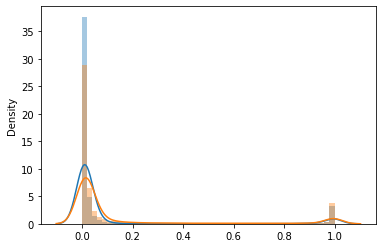

In [97]:
import seaborn as sns
sns.distplot(val_preds1)
sns.distplot(val_preds2)

/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

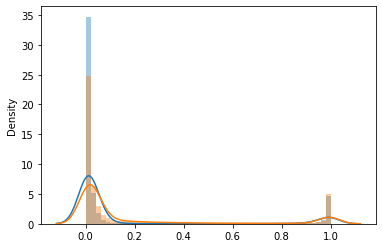

In [83]:
sns.distplot(test_preds)
sns.distplot(test_preds2)

In [271]:
oof_public = pd.read_csv("data/ensemble_oof.csv")
test_public = pd.read_csv("data/submission.csv")
test_public.head()

,id,target
0,00034db451c4,0.008421
1,0006316b5ca0,0.004180
2,0006a953d21b,0.031801
3,0008a33d6695,0.026555
4,00095b5119fc,0.013587


In [272]:
oof_mk = pd.DataFrame({'id': val_ids1, 'target': val_preds1})

In [273]:
oof_mk

,id,target
0,00034abb3629,0.008644
1,000453852fda,0.006878
2,0004be0baf70,0.007843
3,000a6d98b0e4,0.007904
4,000b676ce5ea,0.004467
...,...,...
50160,ffd8142fb1ee,0.002350
50161,ffdc411603f6,0.007812
50162,ffdd19620875,0.011688
50163,fff395e32a1e,0.003551


In [274]:
oof_mk['preds_norm2'] = val_preds2

In [ ]:
from sklearn.linear_model import LogisticRegression


In [351]:
from scipy.stats import gmean
preds = 0.9*np.array(val_preds1)**0.5 + 0.1*np.array(val_preds2)**0.5
roc_auc_score(oof_mk.labels, preds)

0.9897555282686858

In [331]:
oof_mk['preds3'] = preds

In [275]:
oof_mk['preds2'] = oof_mk.id.map(oof_public.set_index('id')['target'])

In [344]:
oof_mk['preds_e2'] = gmean([oof_mk['preds3'], oof_mk['preds2']], 0)

In [345]:
tr = pd.read_csv("data/train_labels.csv")

In [346]:
oof_mk['labels'] = oof_mk.id.map(tr.set_index('id')['target'])

In [347]:
roc_auc_score(oof_mk['labels'].values, oof_mk['preds_e2'].values)

0.9916793537867542

In [296]:
from sklearn.metrics import confusion_matrix
confusion_matrix(oof_mk['labels'], oof_mk['preds_e2'] > 0.7)

array([[45446,    25],
       [  308,  4386]])

In [299]:
oof_mk.loc[(oof_mk['preds_e2'] < 0.7) & (oof_mk['labels'] == 1)]

,id,target,preds_norm2,preds2,preds_e2,labels,flag
91,024a578160ec,0.090881,0.020523,0.052354,0.505172,1,train
150,0386694b90cf,0.035004,0.961914,0.283950,0.609151,1,train
486,0c40d55c1481,0.270752,0.005180,0.018156,0.521557,1,train
661,10d425c3301e,0.098572,0.042084,0.043442,0.503061,1,train
1308,20bbc9da4bb2,0.010452,0.009270,0.037999,0.380156,1,train
...,...,...,...,...,...,...,...
49220,e73d4d525dd4,0.032654,0.030106,0.022611,0.406006,1,train
49470,edf919babe58,0.263916,0.961426,0.022774,0.566284,1,train
49568,f057dddfa8a4,0.708008,0.375977,0.046728,0.684405,1,train
49732,f46b781d6d7a,0.105408,0.037537,0.055762,0.521387,1,train


In [353]:
def plot_image(df, idx):
    ids = df.id.iloc[idx]
    im = np.load(f"data/{df.flag.iloc[idx]}/{ids[0]}/{ids}.npy")[[0, 2, 4]].astype(np.float32)
    #im = im - im.mean(axis=(0, 1), keepdims=True)
    im = np.vstack(im)
    
    im -= im.min()
    im /= im.max()
    plt.figure(figsize=(15, 15))
    plt.imshow(im)
    plt.show()

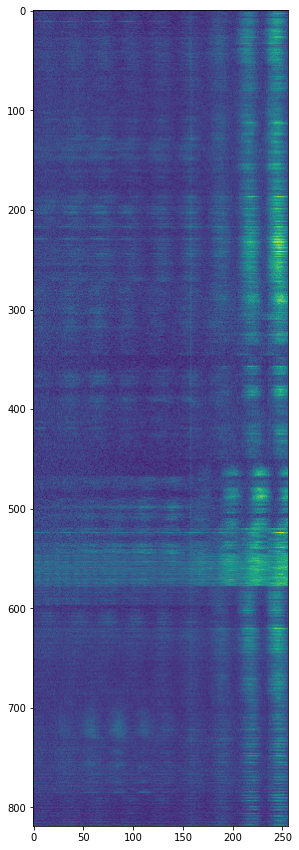

In [356]:
oof_mk['flag'] = "train"
plot_image(oof_mk, 1308)

In [283]:
test_public['target'] = test_public['target'] **0.25 * 0.5 + test_preds **0.25 * 0.45 + test_preds2**0.25*0.05

/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='preds_e2', ylabel='Density'>

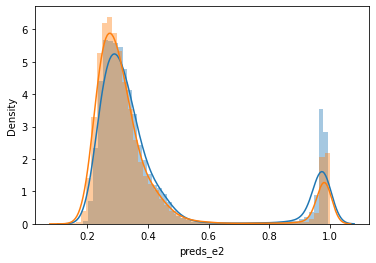

In [284]:
sns.distplot(test_public['target'])
sns.distplot(oof_mk['preds_e2'])

In [285]:
test_public.head()

,id,target
0,00034db451c4,0.315221
1,0006316b5ca0,0.300688
2,0006a953d21b,0.377129
3,0008a33d6695,0.395688
4,00095b5119fc,0.368399


/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

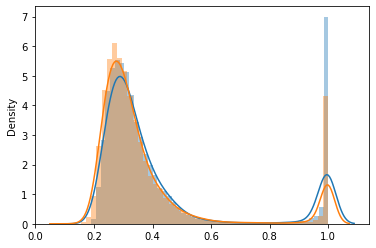

In [292]:
sns.distplot(test_preds**0.25)
sns.distplot(np.array(val_preds1)**0.25)

In [289]:
np.array(val_preds1)

array([0.008644, 0.006878, 0.00784 , ..., 0.01169 , 0.003551, 0.006668],
      dtype=float16)

/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

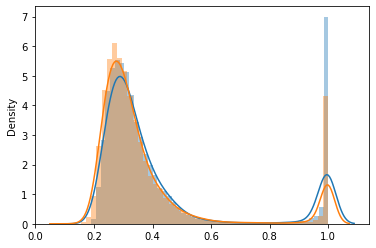

In [290]:
sns.distplot(test_preds**0.25)
sns.distplot(np.array(val_preds1)**0.25)

/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

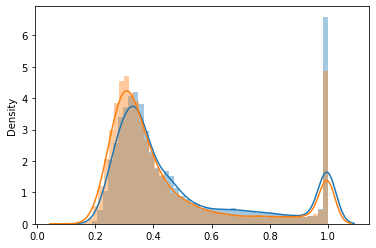

In [291]:
sns.distplot(test_preds2**0.25)
sns.distplot(np.array(val_preds2)**0.25)

In [286]:
test_public.to_csv("data/sub_e5.csv", index=False)

In [28]:
labels

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [359]:
3 * 12

36

In [360]:
model = timm.create_model('efficientnetv2_s', False)
model

EfficientNet(
  (conv_stem): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
      )
    )
    (1): Sequential(
      (0): EdgeResidual(
        (conv_exp): Conv2d(24, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, trac

In [ ]:
class SetiCNN4(nn.Module):
    